<font size="5"><b>Proposal for Group 42 - Heart Failure Fatality</b></font>

<b>Introduction </b>

Cardiovascular diseases, which kill approximately 17 million people in the world, include heart attacks, heart strokes, and heart failure. Heart failure is caused when the heart cannot successfully send the required amount of blood to the body (Chicco, 2020). In this project, we will predict what factors determine whether patients can survive after heart failure. We will use dataset "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv", which includes the data of 299 patients after heart failure at the Faisalabad Institute of Cardiology and at the Allied Hospital in Faisalabad; collected between April 2015 and December 2015. 


In [2]:
library(tidyverse)
library(tidymodels)
library(repr)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [3]:
#reads in data as well as turns relevant double columns into factors 

url<- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"


heart_data <- read_csv(url)%>%
    mutate(sex = as_factor(sex))%>%
    mutate(smoking = as_factor(smoking))%>%
    mutate(DEATH_EVENT = as_factor(DEATH_EVENT))%>%
    mutate(high_blood_pressure = as_factor(high_blood_pressure))%>%
    mutate(diabetes = as_factor(diabetes))%>%
    mutate(anaemia= as_factor(anaemia)) 


#creates factor levels for columns that make sense with column name 
levels(heart_data$sex)<- c("female","male")
levels(heart_data$smoking)<- c("no","yes")
levels(heart_data$DEATH_EVENT)<- c("died","survived")
levels(heart_data$high_blood_pressure)<- c("no","yes")
levels(heart_data$diabetes)<- c("no","yes")
levels(heart_data$anaemia)<- c("no","yes")


#split the data into training and testing data 
heart_data_split<- initial_split(heart_data, prop = .75, strata = DEATH_EVENT)
heart_train<- training(heart_data_split)
heart_test<- testing(heart_data_split)
 

Parsed with column specification:
cols(
  age = col_double(),
  anaemia = col_double(),
  creatinine_phosphokinase = col_double(),
  diabetes = col_double(),
  ejection_fraction = col_double(),
  high_blood_pressure = col_double(),
  platelets = col_double(),
  serum_creatinine = col_double(),
  serum_sodium = col_double(),
  sex = col_double(),
  smoking = col_double(),
  time = col_double(),
  DEATH_EVENT = col_double()
)



The above code writes in our data as well as does some wrangling and preparing for classifying. In the first block of code changes all categories to factors that we migth want to use as predictors. The second block of code changes the columns to have classifications that make sense with their variable instead of just binary 1 or 0. The last block of code splits the data into training and testing data with proportion  

In [4]:
#Looking at the distribution of each categorical variable in the dataset to see which ones are viable for classification. 
num_obs <- nrow(heart_train)
anaemia_dist <- heart_train %>% 
  group_by(anaemia) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
diabetes_dist <- heart_train %>% 
  group_by(diabetes) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
bp_dist <- heart_train %>% 
  group_by(high_blood_pressure) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )
death_dist <- heart_train %>% 
  group_by(DEATH_EVENT) %>% 
  summarize(
    count = n(),
    percentage = n() / num_obs * 100
  )

anaemia_dist
diabetes_dist
bp_dist
death_dist

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



anaemia,count,percentage
<fct>,<int>,<dbl>
no,123,54.66667
yes,102,45.33333


diabetes,count,percentage
<fct>,<int>,<dbl>
no,134,59.55556
yes,91,40.44444


high_blood_pressure,count,percentage
<fct>,<int>,<dbl>
no,149,66.22222
yes,76,33.77778


DEATH_EVENT,count,percentage
<fct>,<int>,<dbl>
died,153,68
survived,72,32


The distribution of all categorical classes can be seen above, since range of their distrubutions is within 10, statistically any of them can be chosen as a viable class to predict. However, due to the medical significance and strength of corelation to the features, we decided to choose "DEATH_EVENT" as the class which we will try to predict.

Following this analysis, all other categorical data types were removed from the dataframe. 

In [5]:
# # remove categorical columns from the dataset and only keep numerical
# heart_numerical <- heart_data %>% 
#     select(-anaemia, -diabetes, -high_blood_pressure, -sex, -smoking, -time)

# CODE TO SELECT THE BEST PREDICTOR VARIABLES

# #Evaluate which predictive variables to choose

# # create object of names of all predictive variables
# names <- colnames(heart_numerical %>% select(-DEATH_EVENT))

# # create an empty tibble to store the results
# accuracies <- tibble(size = integer(), 
#                      model_string = character(), 
#                      accuracy = numeric())

# # create a model specification
# knn_spec <- nearest_neighbor(weight_func = "rectangular", 
#                              neighbors = tune()) %>% 
#      set_engine("kknn") %>% 
#      set_mode("classification")

# # create a 5-fold cross-validation object
# heart_vfold <- vfold_cv(heart_numerical, v = 5, strata = DEATH_EVENT)

# # store the total number of predictors
# n_total <- length(names)

# # stores selected predictors
# selected <- c()

# # for every size from 1 to the total number of predictors
# for (i in 1:n_total) {
#     # for every predictor still not added yet
#     accs <- list()
#     models <- list()
#     for (j in 1:length(names)) {
#         # create a model string for this combination of predictors
#         preds_new <- c(selected, names[[j]])
#         model_string <- paste("DEATH_EVENT", "~", paste(preds_new, collapse="+"))

#         # create a recipe from the model string
#         heart_recipe <- recipe(as.formula(model_string), 
#                                 data = heart_numerical) %>% 
#                           step_scale(all_predictors()) %>% 
#                           step_center(all_predictors())

#         # tune the KNN classifier with these predictors, 
#         # and collect the accuracy for the best K
#         acc <- workflow() %>% 
#           add_recipe(heart_recipe) %>% 
#           add_model(knn_spec) %>% 
#           tune_grid(resamples = heart_vfold, grid = 10) %>% 
#           collect_metrics() %>% 
#           filter(.metric == "accuracy") %>% 
#           summarize(mx = max(mean))
#         acc <- acc$mx %>% unlist()

#         # add this result to the dataframe
#         accs[[j]] <- acc
#         models[[j]] <- model_string
#     }
#     jstar <- which.max(unlist(accs))
#     accuracies <- accuracies %>% 
#       add_row(size = i, 
#               model_string = models[[jstar]], 
#               accuracy = accs[[jstar]])
#     selected <- c(selected, names[[jstar]])
#     names <- names[-jstar]
# }

# accuracies

<b>NOTE</b>: The above code takes around 1.5 minutes to run as it uses forward propagation to see which predictor variables might be the most effective in predicting death event. Thus, the cell has been commented out so it doesn't get computer everytime the noterbook is run. We still use the results of that the code above provides for the rest of our report. We will uncomment when submitting the final version. 

From this table we can see that the ejection fraction and age have the greates accuracy for predicting a death event. However, sinceit is clear older age is more likely to lead to a death event we will use the second most accurate set of predictors which is ejection fraction and serum creatine without age. 

Therefore, the research question which we will try to answer in this project is: To what extent do ejection fraction and serum creatine levels affect the death possibility of a person if they suffer from heart failure? 

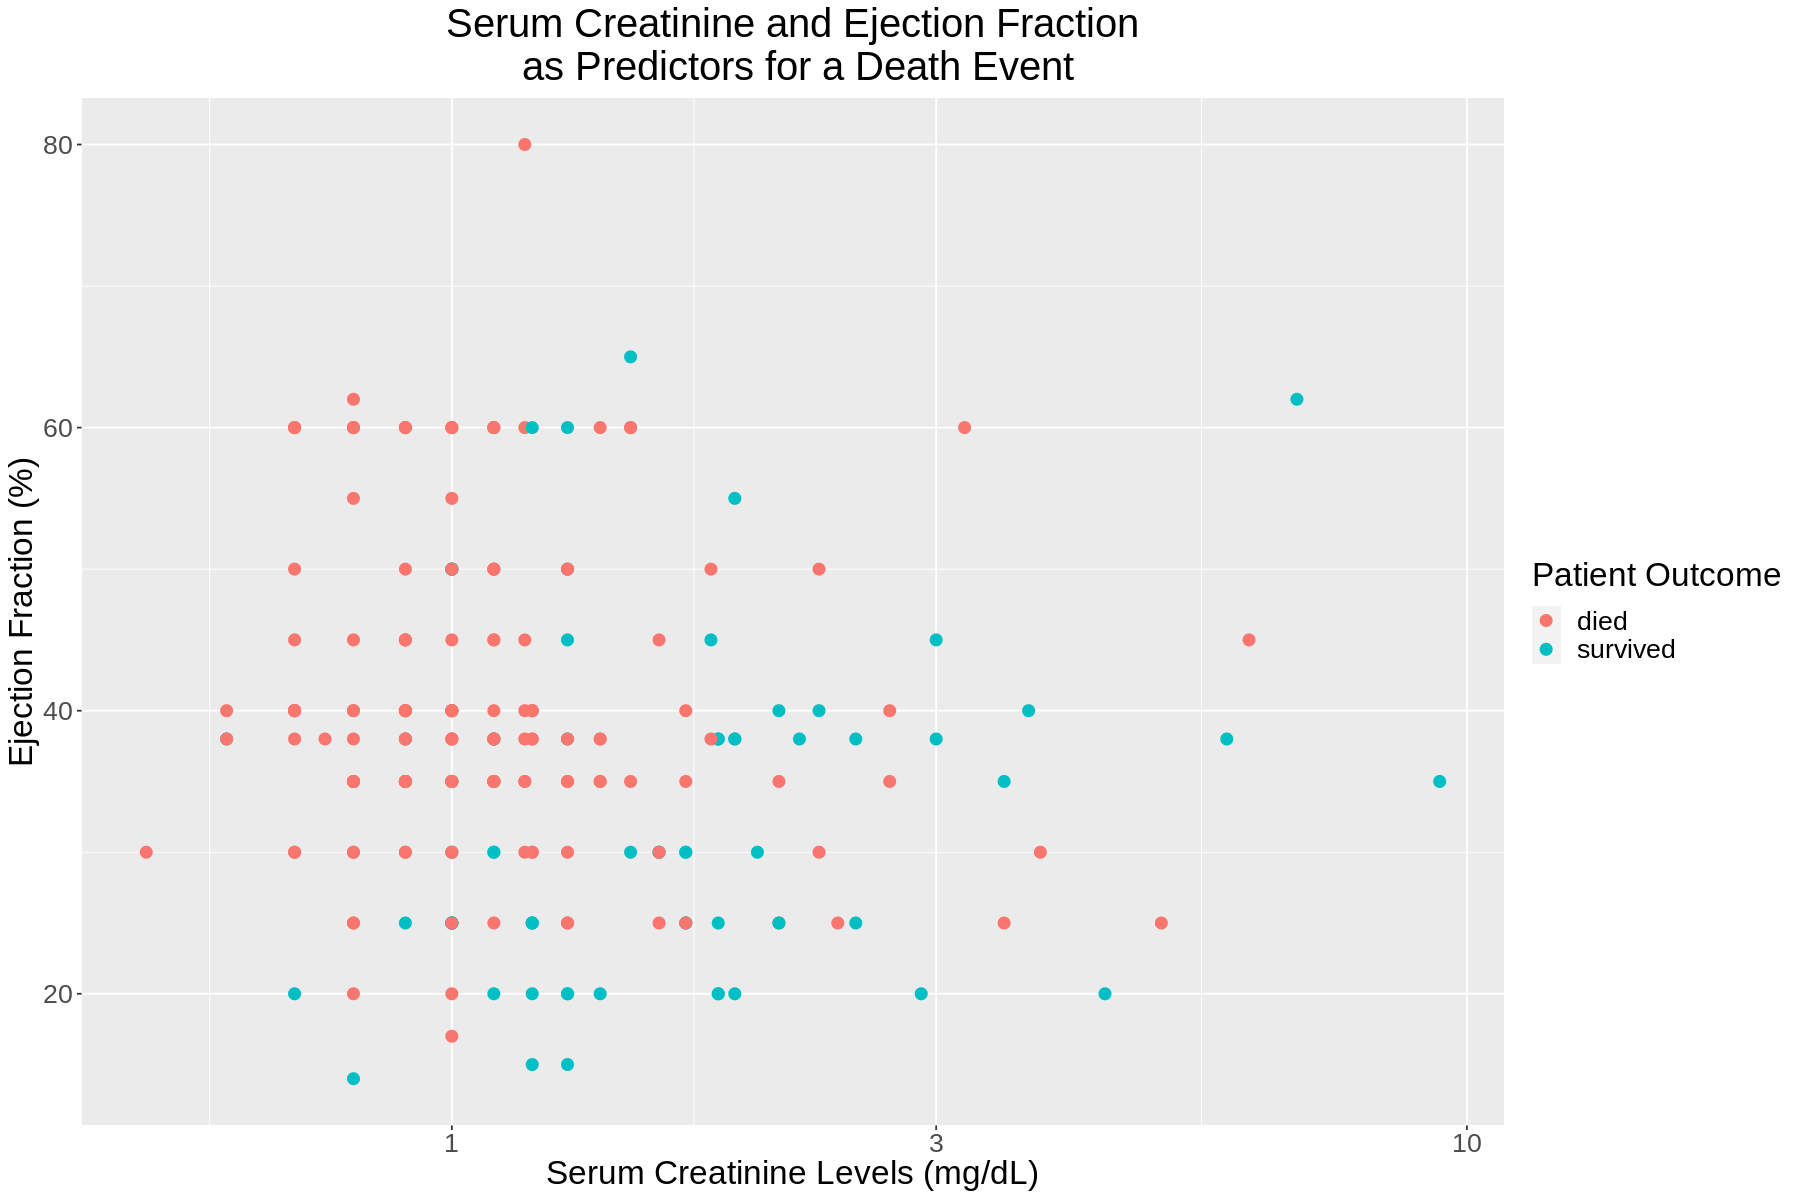

In [8]:
options(repr.plot.height = 10, repr.plot.width = 15)

heart_plot<- heart_train%>%
    ggplot(aes(x= serum_creatinine, y = ejection_fraction))+
    geom_point(aes(color = DEATH_EVENT), size = 3)+
    labs(x = "Serum Creatinine Levels (mg/dL)", y = "Ejection Fraction (%)", 
         title = "Serum Creatinine and Ejection Fraction\n as Predictors for a Death Event",
         color = "Patient Outcome")+
    theme(text = element_text(size = 20), plot.title = element_text(hjust = .5))+
    scale_x_log10()

heart_plot

The plot above shows the distribution of our two predictors in relation to our variable that we are trying to predict, death event (in this graph it is labeled as patient outcome, but that is the same as death event).

<b>Expected outcomes and significance</b>

We expect to find that serum creatine and ejection fraction can accuratly predict if a patient who has already suffered heart failure is likely to survive in the following days. By taking these predictors and applying them to new patients who have suffered heart failure we can make accurate predictions about what the this patients survival in the following days after their heart failure. This can help hospitals identify which patients will need special care and treatment in the following days after heart failure in order to increase chance of survival. Future studies may want to recreate this study in other datasets as well as larger datasets in order to improve reliability. They may also want to look at these variables as predictors for other diseases and illnesses such as renal failure and high blood pressure.